In [24]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import arviz as az

In [2]:
def u236_of_enrichment(enrichment):
    return 1e-5 * (9.4 + 0.6 * np.log(enrichment/100))

In [9]:
u236_of_enrichment(90)

9.336783690605306e-05

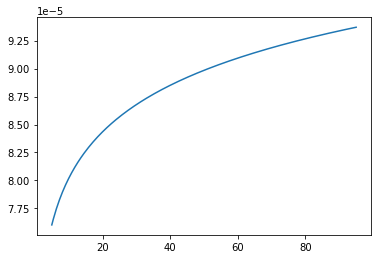

In [10]:
xs = np.linspace(5, 95, 200)
plt.plot(xs, u236_of_enrichment(xs))

## What?

We model the enrichment curve using `u236_of_enrichment()`, which slightly looks like the real enrichment curve. It doesn't really matter, but this way we can more easily compare.

We take `observations` that in reality would come from cyclus; they are randomly distributed around the "true" U-236 concentration shown above; our enrichment grade is 90%, and we aim to reconstruct this value.

We then sample different enrichments from \[5, 95\]% -- just like in the real model. For each enrichment we short-circuit the whole Cyclus business and plug in `u236_of_enrichment()` instead. The observed distribution calculates the likelihood from the previously generated observations. This mechanism is different from the one employed in the model, but should result in a similarly structured likelihood function.

In [26]:
def run_pathological_model_1(sigma):
    # Our observed U236 concentrations. This imitates the results from Cyclus.
    observations = pm.TruncatedNormal.dist(
        mu=9.33678e-5, sigma=sigma, lower=8.7e-5, upper=9.6e-5).random(size=100)
    
    with pm.Model() as model:
        enrichment = pm.Uniform('enrichment', lower=5, upper=95)
        u236_conc = pm.Deterministic('u236_conc', u236_of_enrichment(enrichment))
        
        pm.Normal('observed', mu=u236_conc, sigma=sigma, observed=observations)
        
        trace = pm.sample(2000, return_inferencedata=True)
        az.plot_trace(trace, figsize=(20, 6))

## Experiment

As we see below, if `sigma` is much larger (`1e-4`) than the *observed* interval (`8.7e-5 - 9.6e-5 => 9e-6`), then no useful information can be extracted.

Once `sigma` falls below the *observed interval*, we see accurate reconstructions (`sigma = 1e-6`).

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enrichment]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


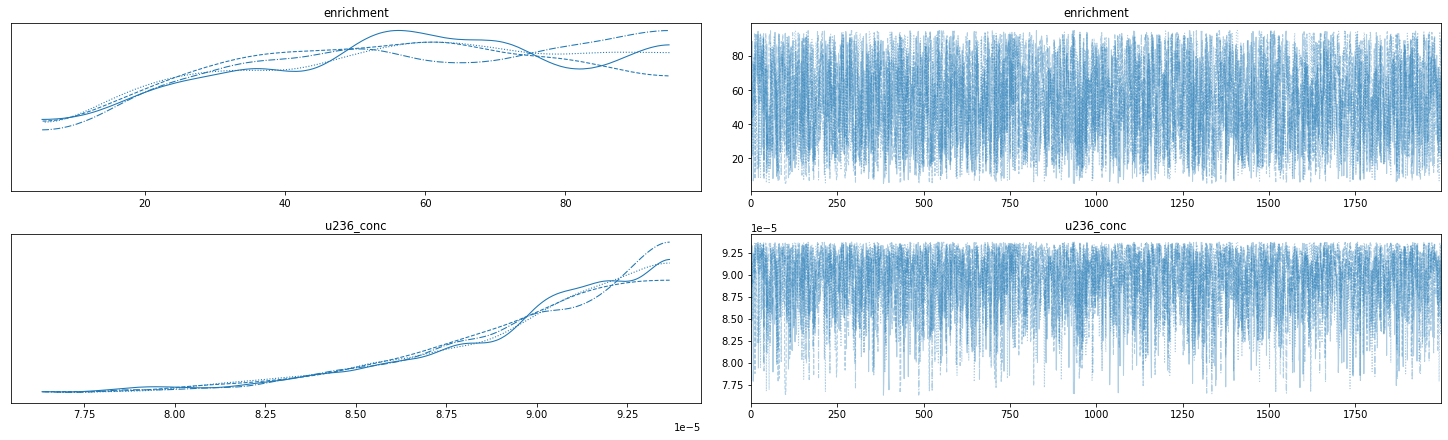

In [27]:
run_pathological_model_1(sigma=1e-4)

In [ ]:
run_pathological_model_1(sigma=1e-5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [enrichment]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.6201524097970085, but should be close to 0.8. Try to increase the number of tuning steps.


In [ ]:
run_pathological_model_1(sigma=1e-6)